<a href="https://colab.research.google.com/github/ejrtks1020/Deep_Learning/blob/main/CatnDog_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 개와 고양이 데이터 세트의 디렉토리와 파일을 기반으로 메타 정보용 DataFrame 생성 

In [1]:
!pip install kaggle --upgrade

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = 'asdsadwqrr'
os.environ['KAGGLE_KEY'] = 'fcd162570bf9e9f427cde4418405b341'

In [3]:
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions        Commands related to Kaggle competitions
    datasets            Commands related to Kaggle datasets
    kernels             Commands related to Kaggle kernels
    config              Configuration settings


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog

 94% 205M/218M [00:01<00:00, 178MB/s]
100% 218M/218M [00:01<00:00, 160MB/s]


In [5]:
!mkdir ./cat_dog
!unzip '*.zip' -d ./cat_dog

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./cat_dog/training_set/training_set/cats/cat.3704.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3705.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3706.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3707.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3708.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3709.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.371.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3710.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3711.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3712.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3713.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3714.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3715.jpg  
  inflating: ./cat_dog/training_set/training_set/cats/cat.3716.jpg  

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

def make_catndog_dataframe():
    paths = []
    dataset_gubuns = []
    label_gubuns = []
    # os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
    # cat-and-dog 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
    # cat-and-dog 밑으로 /train/, /test/ 하위 디렉토리 존재(학습, 테스트 용 이미지 파일들을 가짐)

    for dirname, _, filenames in os.walk('/content/cat_dog'):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
                # 파일의 절대 경로에 training_set, test_set가 포함되어 있으면 데이터 세트 구분을 'train'과 'test'로 분류. 
                if '/training_set/' in file_path:
                    dataset_gubuns.append('train')  
                elif '/test_set/' in file_path:
                    dataset_gubuns.append('test')
                else: dataset_gubuns.append('N/A')

                # 파일의 절대 경로에 dogs가 있을 경우 해당 파일은 dog 이미지 파일이고, cats일 경우는 cat 이미지 파일임. 
                if 'dogs' in file_path:
                    label_gubuns.append('DOG')
                elif 'cats' in file_path:
                    label_gubuns.append('CAT')
                else: label_gubuns.append('N/A')
    
    data_df = pd.DataFrame({'path':paths, 'dataset':dataset_gubuns, 'label':label_gubuns})
    return data_df

In [7]:
pd.set_option('display.max_colwidth', 200)
data_df = make_catndog_dataframe()
print('data_df shape:', data_df.shape)
data_df.head()

data_df shape: (10028, 3)


,path,dataset,label
0,/content/cat_dog/test_set/test_set/dogs/dog.4767.jpg,test,DOG
1,/content/cat_dog/test_set/test_set/dogs/dog.4452.jpg,test,DOG
2,/content/cat_dog/test_set/test_set/dogs/dog.4399.jpg,test,DOG
3,/content/cat_dog/test_set/test_set/dogs/dog.4796.jpg,test,DOG
4,/content/cat_dog/test_set/test_set/dogs/dog.4151.jpg,test,DOG


### Keras Sequence를 상속받은 Dataset 객체를 생성

In [8]:
list_a = [1, 2, 3, 4, 5]
print(len(list_a)) # __len__(self) 호출
print(list_a[0]) # __getitem__(self, index)

5
1


In [9]:
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

# 배치 크기와 이미지 크기를 전역 변수로 선언 
BATCH_SIZE = 64
IMAGE_SIZE = 224

# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    
    # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당.
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        # train data의 경우 
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
            
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다.
        return int(np.ceil(len(self.labels)/self.batch_size))
        
    def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음.
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
        
            image_batch[image_index] = image
       
        return image_batch, label_batch
            
            
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

### Sequence 기반 Dataset을 생성하고 호출하기
* albumentations를 이용하여 BATCH 크기 만큼 데이터를 Augmentation 한 뒤 데이터를 반환 할 수 있는 Sequence 기반 Dataset을 생성하고 호출하기 

In [10]:
import albumentations as A

# 전체 데이터 세트에서 학습과 테스트용 메타 정보 DataFrame 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# image file의 위치가 있는 데이터와 label값을 numpy array로 변환. 
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values

cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

In [11]:
train_image_filenames.shape

(8005,)

In [12]:
#next(iter(cnd_ds))
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64,)
[[[ 19.  19.  21.]
  [ 20.  20.  22.]
  [ 16.  16.  18.]
  ...
  [ 16.  15.   9.]
  [ 10.   7.   1.]
  [ 14.  11.   5.]]

 [[ 16.  16.  18.]
  [ 16.  16.  18.]
  [ 17.  17.  19.]
  ...
  [  9.   8.   2.]
  [ 14.  11.   4.]
  [ 11.   9.   2.]]

 [[ 18.  18.  20.]
  [ 18.  18.  20.]
  [ 14.  14.  16.]
  ...
  [ 13.  11.   7.]
  [ 12.   9.   4.]
  [ 15.  12.   5.]]

 ...

 [[ 97. 110. 127.]
  [ 91. 104. 121.]
  [ 88. 101. 118.]
  ...
  [ 60.  60.  62.]
  [ 63.  63.  65.]
  [ 63.  63.  65.]]

 [[ 94. 105. 123.]
  [ 99. 110. 128.]
  [ 99. 110. 128.]
  ...
  [ 67.  67.  70.]
  [ 75.  75.  77.]
  [ 78.  78.  80.]]

 [[ 99. 110. 128.]
  [101. 112. 130.]
  [ 94. 105. 123.]
  ...
  [ 77.  77.  79.]
  [ 82.  82.  84.]
  [ 85.  85.  87.]]]


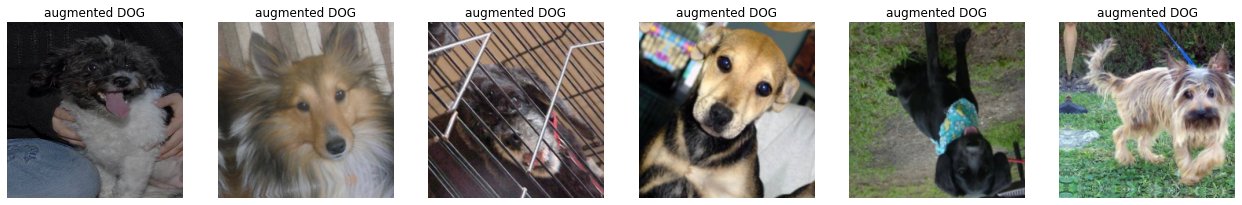

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # image_batch는 float형이므로 int형으로 변경하여 이미지 시각화
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i]) 
        
show_grid_images(images_batch, ncols=6, title='augmented ' + labels_batch)

### 원본 이미지 픽셀값의 scaling을 감안하여 다시 CnD_Dataset 재 작성. 

In [14]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 이미지 값을 0 ~ 1 로 스케일링. 
            image = image/255.0
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [15]:
# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(64, 224, 224, 3) (64,)
[[[[0.49411765 0.49411765 0.49411765]
   [0.47058824 0.47058824 0.47058824]
   [0.45490196 0.45490196 0.44705883]
   ...
   [0.27058825 0.34117648 0.42745098]
   [0.2784314  0.34901962 0.43529412]
   [0.27450982 0.34509805 0.43137255]]

  [[0.49803922 0.49803922 0.49803922]
   [0.4745098  0.4745098  0.4745098 ]
   [0.46666667 0.4627451  0.4509804 ]
   ...
   [0.2901961  0.36078432 0.44705883]
   [0.28627452 0.35686275 0.44313726]
   [0.2627451  0.33333334 0.41960785]]

  [[0.49019608 0.49019608 0.49019608]
   [0.47058824 0.47058824 0.46666667]
   [0.45882353 0.45490196 0.44313726]
   ...
   [0.28627452 0.35686275 0.44313726]
   [0.26666668 0.3372549  0.42745098]
   [0.27450982 0.34509805 0.43137255]]

  ...

  [[0.1764706  0.1882353  0.19215687]
   [0.17254902 0.1882353  0.19215687]
   [0.17254902 0.1882353  0.19215687]
   ...
   [0.03921569 0.03921569 0.04705882]
   [0.08235294 0.08235294 0.09019608]
   [0.07450981 0.07450981 0.08235294]]

  [[0.14117648 0.1450

### Pretrained 모델에서 사용하는 보다 범용적인 Preprocessing을 적용할 수 있도록 재작성. 
* pre_func 인자를 추가하여 pretrained 모델의 preprocess_input 함수를 인자로 입력할 수 있도록 수정. 

In [16]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [17]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(64, 224, 224, 3) (64,)
[[[[-0.3333333  -0.3333333  -0.31764704]
   [-0.35686272 -0.35686272 -0.34117645]
   [-0.3960784  -0.3960784  -0.38039213]
   ...
   [-0.26274508 -0.17647058 -0.03529412]
   [-0.20784312 -0.12156862  0.0196079 ]
   [-0.2235294  -0.1372549   0.00392163]]

  [[-0.38823527 -0.38823527 -0.372549  ]
   [-0.41176468 -0.41176468 -0.3960784 ]
   [-0.47450978 -0.47450978 -0.45098037]
   ...
   [-0.2235294  -0.1372549   0.00392163]
   [-0.2235294  -0.1372549   0.00392163]
   [-0.26274508 -0.17647058 -0.03529412]]

  [[-0.5058824  -0.5058824  -0.49019605]
   [-0.5058824  -0.5058824  -0.49019605]
   [-0.5294118  -0.5294118  -0.5137255 ]
   ...
   [-0.3098039  -0.20784312 -0.0745098 ]
   [-0.2862745  -0.18431371 -0.05098039]
   [-0.23921567 -0.1372549  -0.00392157]]

  ...

  [[-0.88235295 -0.90588236 -0.9607843 ]
   [-0.90588236 -0.92941177 -0.96862745]
   [-0.8980392  -0.9137255  -0.94509804]
   ...
   [-0.8901961  -0.8901961  -0.8745098 ]
   [-0.85882354 -0.85882354 -0.84

### 별도의 preprocessing 함수나 Albumentations의 Normalize 적용 가능 

In [18]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

def zero_one_scaler(image):
    return image/255.0

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=zero_one_scaler)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]

images_batch[0:2]

array([[[[0.4627451 , 0.4392157 , 0.4392157 ],
         [0.4627451 , 0.4392157 , 0.4392157 ],
         [0.46666667, 0.44313726, 0.44313726],
         ...,
         [0.3529412 , 0.4117647 , 0.49411765],
         [0.37254903, 0.43137255, 0.5137255 ],
         [0.35686275, 0.41568628, 0.49803922]],

        [[0.47058824, 0.44705883, 0.44705883],
         [0.4627451 , 0.4392157 , 0.4392157 ],
         [0.4745098 , 0.4509804 , 0.4509804 ],
         ...,
         [0.2901961 , 0.34901962, 0.43137255],
         [0.3137255 , 0.37254903, 0.45490196],
         [0.32941177, 0.3882353 , 0.47058824]],

        [[0.49019608, 0.46666667, 0.46666667],
         [0.47843137, 0.45490196, 0.45490196],
         [0.49019608, 0.46666667, 0.46666667],
         ...,
         [0.32941177, 0.3882353 , 0.47058824],
         [0.32156864, 0.38039216, 0.4627451 ],
         [0.30980393, 0.36862746, 0.4509804 ]],

        ...,

        [[0.05882353, 0.05882353, 0.06666667],
         [0.05490196, 0.05490196, 0.0627451 ]

In [19]:
cnd_augmentor_normalized = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor_normalized, shuffle=False, pre_func=None)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
images_batch[0]

array([[[-0.42255333, -0.10994395,  0.4264924 ],
        [-0.38830385, -0.07492995,  0.46135077],
        [-0.5081771 , -0.19747896,  0.3393464 ],
        ...,
        [-0.7992979 , -0.687675  , -0.4275381 ],
        [-0.7136741 , -0.60014   , -0.3403921 ],
        [-0.6622999 , -0.547619  , -0.28810453]],

       [[-0.5081771 , -0.19747896,  0.3393464 ],
        [-0.42255333, -0.10994395,  0.4264924 ],
        [-0.42255333, -0.10994395,  0.4264924 ],
        ...,
        [-0.9705455 , -0.86274505, -0.58440083],
        [-0.8335474 , -0.72268903, -0.46239647],
        [-0.78217316, -0.670168  , -0.4101089 ]],

       [[-0.45680285, -0.10994395,  0.4090632 ],
        [-0.55955136, -0.21498597,  0.30448803],
        [-0.6109256 , -0.26750696,  0.25220045],
        ...,
        [-1.0904187 , -0.98529404, -0.7238344 ],
        [-1.0390445 , -0.93277305, -0.6715468 ],
        [-1.0390445 , -0.93277305, -0.6715468 ]],

       ...,

       [[-1.8096584 , -1.7205881 , -1.4558605 ],
        [-1

### 학습, 검증 데이터 분할 및 레이블 인코딩 적용 

In [20]:
pd.factorize(train_df['label'])

(array([0, 0, 0, ..., 1, 1, 1]), Index(['DOG', 'CAT'], dtype='object'))

In [21]:
pd.get_dummies(train_df['label']).values

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [22]:
labels_ohe = pd.get_dummies(train_df['label']).values
print(labels_ohe[:5])

labels_enc = pd.factorize(train_df['label'])[0]
print(labels_enc[:5])

print(labels_ohe.shape, labels_enc.shape)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
[0 0 0 0 0]
(8005, 2) (8005,)


In [23]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터용 Dataframe 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
train_path = train_df['path'].values
train_label = pd.factorize(train_df['label'])[0]


tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
print('학습용 path shape:', tr_path.shape, '검증용 path shape:', val_path.shape, 
      '학습용 label shape:', tr_label.shape, '검증용 label shape:', val_label.shape)

학습용 path shape: (6804,) 검증용 path shape: (1201,) 학습용 label shape: (6804,) 검증용 label shape: (1201,)


In [24]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.3),
    #A.VerticalFlip(p=0.5),
    #A.ShiftScaleRotate(p=0.5)
])

In [25]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, 
                      shuffle=True, pre_func=xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)

print(tr_image_batch[:1])
print(val_image_batch[:1])


(64, 224, 224, 3) (64, 224, 224, 3)
[[[[-0.1372549  -0.14509803 -0.08235294]
   [-0.12156862 -0.12941176 -0.06666666]
   [-0.1607843  -0.16862744 -0.10588235]
   ...
   [-0.08235294 -0.08235294 -0.09803921]
   [-0.1372549  -0.1372549  -0.14509803]
   [-0.16862744 -0.16862744 -0.18431371]]

  [[-0.16862744 -0.17647058 -0.11372548]
   [-0.12941176 -0.1372549  -0.06666666]
   [-0.12941176 -0.1372549  -0.0745098 ]
   ...
   [-0.04313725 -0.04313725 -0.05882353]
   [-0.08235294 -0.08235294 -0.10588235]
   [-0.10588235 -0.10588235 -0.12156862]]

  [[-0.19215685 -0.19999999 -0.1372549 ]
   [-0.12941176 -0.1372549  -0.0745098 ]
   [-0.11372548 -0.12156862 -0.05882353]
   ...
   [-0.03529412 -0.03529412 -0.05098039]
   [-0.05882353 -0.05882353 -0.0745098 ]
   [-0.06666666 -0.06666666 -0.08235294]]

  ...

  [[-0.8039216  -0.9137255  -0.9372549 ]
   [-0.77254903 -0.88235295 -0.90588236]
   [-0.8117647  -0.92156863 -0.9372549 ]
   ...
   [-0.09019607 -0.15294117 -0.16862744]
   [ 0.05098045 -0.01

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 최종 output 출력을 softmax에서 sigmoid로 변환. 
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [27]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = create_model(model_name='xception')
# 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

83697664/83683744 [==============================] - 0s 0us/step


In [28]:
len(val_ds) # __len__

19

In [29]:
N_EPOCHS = 15
history = model.fit(tr_ds, epochs=N_EPOCHS, 
                    steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                    validation_data=val_ds, 
                    validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/15
107/107 [==============================] - 99s 812ms/step - loss: 0.1174 - accuracy: 0.9578 - val_loss: 0.5789 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 84s 782ms/step - loss: 0.0608 - accuracy: 0.9753 - val_loss: 0.2044 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 84s 783ms/step - loss: 0.0692 - accuracy: 0.9752 - val_loss: 0.2230 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 84s 781ms/step - loss: 0.0390 - accuracy: 0.9874 - val_loss: 0.1173 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 84s 782ms/step - loss: 0.0319 - accuracy: 0.9887 - val_loss: 0.1140 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - 84s 782ms/step - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.2495 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 7/15
107/107 [==============================] 

### 테스트용 Dataset 생성 후 성능 검증 

In [30]:
test_df = data_df[data_df['dataset']=='test']

# 테스트 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
test_path = test_df['path'].values
test_label = pd.factorize(test_df['label'])[0]

test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

model.evaluate(test_ds)

32/32 [==============================] - 8s 248ms/step - loss: 0.0748 - accuracy: 0.9857


[0.07482120394706726, 0.9856648445129395]

### 다른 Pretrained 모델을 이용하여 성능 테스트 

In [31]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

def get_train_valid_test(data_df):
    # 학습 데이터와 테스트 데이터용 Dataframe 생성. 
    train_df = data_df[data_df['dataset']=='train']
    test_df = data_df[data_df['dataset']=='test']

    # 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
    train_path = train_df['path'].values
    train_label = pd.factorize(train_df['label'])[0]
    
    test_path = test_df['path'].values
    test_label = pd.factorize(test_df['label'])[0]

    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
    
    return tr_path, tr_label, val_path, val_label, test_path, test_label
    
    
def do_train_evaluation(data_df, model_name, augmentor, preprocessing_func):
    # 학습/검증/테스트용 이미지 파일 절대경로와 Label encoding 된 데이터 세트 반환
    tr_path, tr_label, val_path, val_label, test_path, test_label = get_train_valid_test(data_df)
    
    # 학습과 검증용 Sequence Dataset 생성. 
    tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                          shuffle=True, pre_func=preprocessing_func)
    val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)
    
    # 입력된 model_name에 따라 모델 생성. 
    model = create_model(model_name=model_name)
    # 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # 2번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
    # 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

    N_EPOCHS = 15
    # 학습 수행. 
    history = model.fit(tr_ds, epochs=N_EPOCHS, steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                       validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                       callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    # 테스트용 Sequence Dataset 생성후 evaluation 수행. 
    test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)

    evaluation_result = model.evaluate(test_ds)
    print(evaluation_result)
    return history, evaluation_result



In [32]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor1 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(p=0.2),
    A.RandomBrightnessContrast(p=0.2)
])

history1, result1 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor1, mobile_preprocess_input)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/15
107/107 [==============================] - 44s 370ms/step - loss: 0.1394 - accuracy: 0.9427 - val_loss: 0.6214 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 39s 359ms/step - loss: 0.0862 - accuracy: 0.9660 - val_loss: 4.0507 - val_accuracy: 0.6994 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 39s 359ms/step - loss: 0.0677 - accuracy: 0.9753 - val_loss: 0.5864 - val_accuracy: 0.9309 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 38s 358ms/step - loss: 0.0598 - accuracy: 0.9782 - val_loss: 0.7655 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 38s 356ms/step - loss: 0.0535 - accuracy: 0.9816 - val_loss: 4.3334 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9809
Epoch 00006: ReduceLROnPlateau reducing learning ra

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor2 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ColorJitter(p=0.2),
    A.CLAHE(p=0.2),
    A.Cutout(p=0.2)
])

history2, result2 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor2, mobile_preprocess_input)

In [ ]:
tf.keras.backend.clear_session()

cnd_augmentor3 = A.Compose([
    A.HorizontalFlip(p=0.3)
])

history3, result3 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor3, mobile_preprocess_input)